# North Branch of the Potomac Watershed

by: John Kucharksi | correspondance: johnkucharski@gmail.com | date: 06 May 2021 

The notebook analyzes the spatial patterns of extreme precipitation events in the North Branch of the Potomac Watershed, using the Livneh daily precipitation data and USGS 8 digit hydrologic unit code watershed boundary shapefile.$^{1, 2}$ </br>
  
References: <br>
$^{1}$ Livneh B., E.A. Rosenberg, C. Lin, B. Nijssen, V. Mishra, K.M. Andreadis, E.P. Maurer, and D.P. Lettenmaier, 2013: A Long-Term Hydrologically Based Dataset of Land Surface Fluxes and States for the Conterminous United States: Update and Extensions, Journal of Climate, 26, 9384–9392. <br>
$^{2}$ U.S. Geological Survey, 2020, National Waterboundary Dataset for 2 digit hydrologic Unit (HU) 02 (mid-atlantic), accessed April 11, 2020 at URL http://prd-tnm.s3-website-us-west-2.amazonaws.com/?prefix=StagedProducts/Hydrography/WBD/HU2/Shape/. ** 

**note: more information on the USGS National Hydrography program and products including the water boundary shape files, used in this analysis can be found here: https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products. 

## Data Processing
The first half of this notebook, processes the raw livneh data.

In [1]:

projpath: str = '/Users/johnkucharski/Documents/source/locus/'

import sys
from typing import List, Dict, Tuple
sys.path.insert(0, projpath)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import src.locus as locus
import src.livneh as livneh
from src.waterboundary import Waterboundary


### Folder Structure
The data for this analysis are stored in the following directory structure:

data/ </br>
&emsp;  |- input/ </br>
&emsp;  |&emsp; |- livneh/ </br>
&emsp;  |&emsp; |&emsp; '- prec.YEAR.nc (YEAR = 4-digit year [1915-2011])</br>
&emsp;  |&emsp; '- waterboundary/  </br>
&emsp;  |&emsp;  &emsp; '- WBD_XX_HU2_Shape/Shape/ (XX = 2-digit USGS HUC code) </br>
&emsp;  |&emsp;  &emsp; &emsp;  |- WBDHUZZ.shp (ZZ = 1 or 2-digit HUC code size) </br>
&emsp;  |&emsp;  &emsp; &emsp;  '- other related files (.shx, .cpg, .dbf, .sbn, etc.) </br>
&emsp;  '- output/ </br>
&emsp;   &emsp; '- northbranch ** </br>
&emsp;   &emsp;  &emsp; |- ams/ </br>
&emsp;   &emsp;  &emsp; |&emsp;  '- Ndy_events.csv (N = duration in days) </br>
&emsp;   &emsp;  &emsp; |&emsp;  '- Ndy_grids.csv  (N = duration in days) </br>
&emsp;   &emsp;  &emsp; '- pds/ </br>
&emsp;   &emsp;  &emsp; |&emsp;  '- Ndy_events.csv (N = duration in days) </br>
&emsp;   &emsp;  &emsp; |&emsp;  '- Ndy_grids.csv (N = duration in days) </br>
&emsp;   &emsp;  &emsp; '- prec.YEAR.csv (YEAR = 4-digit year [1915, 2011])

**note: to generalize this the folder structure between the outputs and the northbranch folder (a HUC08) should include folders with the HUC 2, 4, and 6 names.




### Inputs

In [2]:
inputs: str = f'{projpath}data/input/'

The data being analyzed is daily gridded precipitation depths recorded from 1915 through 2011 in the North Branch of the Potomac Watershed in Western Maryland, USA. 
The data for each day contains the preciptation depth in all 130 livneh grid cells (1/16th of a degree of latitude/longitude) located within or intersected by the North Branch of the Potomac 8 digit Hydrologic Unit Code (HUC08) boundary.

### Outputs

In [3]:

output: str = f'{projpath}data/output/northbranch/'

The output data from this notebook are livneh files that collectively contain the partial duration series (PDS) from a peak over threshold analysis, that yields of days in the livneh record in which the rainfall exceeds the minimum annual maximum basin average value.

In [4]:
huc_code: str = '02070002'
fpath: str = f'{inputs}waterboundary/'
wbd = Waterboundary(path=fpath, code=huc_code).import_waterboundary()
wbd_area = wbd.iloc[0].AreaSqKm
wbd.head()

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,AreaSqKm,AreaAcres,GNIS_ID,Name,States,HUC8,Shape_Leng,Shape_Area,geometry
87,88,{57DA0D48-3009-46C6-8CE5-8ED60DEEBA2C},None,None,None,None,2012-06-11,3478.65,859591.63,0,North Branch Potomac,"MD,PA,WV",02070002,4.101937,0.364322,"POLYGON ((-78.70752 39.96502, -78.70687 39.964..."


Later the livneh grids are converted to polygons and clipped to the "wbd" watershed shape, this is a slow process. To speed it up first the netCDF livneh grids are clipped to a boundary box, created in the next cell.

In [5]:
buffer: float = 1/32
# bbox = [west, south, east, north] coordinates
bbox: List[float] = list(wbd.iloc[0].geometry.bounds)
bbox[0] = bbox[0] - buffer
bbox[1] = bbox[1] - buffer
bbox[2] = bbox[2] + buffer
bbox[3] = bbox[3] + buffer

Gathers the list of input .NetCDF file path (as strings) to process, and the output paths (as strings) for the processed .csv files.

In [6]:
srt_paths: List[str] = livneh.inputfilepaths(f'{inputs}livneh/', vars=['prec'], yrs=[i for i in range(1915, 2012)])
end_paths: List[str] = livneh.outputfilepaths(output, srt_paths)

In [7]:
ids = livneh.ids(srt_paths[0], boundarybox=bbox, wbd=wbd).drop(columns=['area_km2', 'area_weight'])
ids.head()

,id,lat,lon,geometry
0,0,39.96875,-78.84375,POINT (-78.84375 39.96875)
1,1,39.96875,-78.78125,POINT (-78.78125 39.96875)
2,2,39.96875,-78.71875,POINT (-78.71875 39.96875)
3,3,39.96875,-78.65625,POINT (-78.65625 39.96875)
4,4,39.96875,-78.59375,POINT (-78.59375 39.96875)


Processes the the livneh precipitation .NetCDF files returning processed .csv files, for the area of interest.

In [8]:
# print_msg = livneh.process_files(srt_paths, end_paths, bbox, wbd)
# print(f'processed: {print_msg}')

Takes the processed .csv livneh files for the area of interest, and returns partial duration (PDS) and annual maximum series (AMS) for the specified list of durations in days.

In [9]:
# print_msg = livneh.compute_series(end_paths, [1, 2, 3])
# print(print_msg)

In [10]:
df = pd.read_csv(f'{output}pds/1dy_grids.csv', index_col=[0])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
1915-01-12,0.013554,0.069683,0.263369,0.044172,0.000339,0.219079,0.651702,0.684060,0.692049,0.457239,...,0.494100,0.136703,0.322889,0.473308,0.352341,0.159991,0.164996,0.012835,0.170131,0.068738
1915-06-02,0.009411,0.050197,0.201249,0.034112,0.000261,0.159980,0.438029,0.547076,0.593185,0.387072,...,0.222225,0.094976,0.252865,0.427547,0.287631,0.074257,0.090748,0.011849,0.156492,0.066757
1915-10-01,0.011702,0.056993,0.227506,0.037063,0.000290,0.197089,0.567877,0.595171,0.617674,0.387359,...,0.529336,0.181522,0.449969,0.636610,0.427497,0.170773,0.175417,0.016958,0.214843,0.086144
1915-12-17,0.012992,0.064005,0.231349,0.039592,0.000302,0.218392,0.608146,0.632530,0.647152,0.400013,...,0.312717,0.091323,0.207479,0.279050,0.191075,0.101212,0.092630,0.007369,0.093502,0.034968
1916-03-22,0.014344,0.071274,0.255844,0.043385,0.000333,0.224714,0.657044,0.717125,0.722888,0.460115,...,0.370775,0.104951,0.251568,0.363392,0.259861,0.111124,0.105077,0.009657,0.124575,0.051280


In [11]:
df_clustered = locus.storm_centers(df) 
df_clustered.head()

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,cluster
1915-01-12,0.013554,0.069683,0.263369,0.044172,0.000339,0.219079,0.651702,0.684060,0.692049,0.457239,...,0.136703,0.322889,0.473308,0.352341,0.159991,0.164996,0.012835,0.170131,0.068738,5
1915-06-02,0.009411,0.050197,0.201249,0.034112,0.000261,0.159980,0.438029,0.547076,0.593185,0.387072,...,0.094976,0.252865,0.427547,0.287631,0.074257,0.090748,0.011849,0.156492,0.066757,0
1915-10-01,0.011702,0.056993,0.227506,0.037063,0.000290,0.197089,0.567877,0.595171,0.617674,0.387359,...,0.181522,0.449969,0.636610,0.427497,0.170773,0.175417,0.016958,0.214843,0.086144,1
1915-12-17,0.012992,0.064005,0.231349,0.039592,0.000302,0.218392,0.608146,0.632530,0.647152,0.400013,...,0.091323,0.207479,0.279050,0.191075,0.101212,0.092630,0.007369,0.093502,0.034968,5
1916-03-22,0.014344,0.071274,0.255844,0.043385,0.000333,0.224714,0.657044,0.717125,0.722888,0.460115,...,0.104951,0.251568,0.363392,0.259861,0.111124,0.105077,0.009657,0.124575,0.051280,5


In [12]:
# grids DB from locus,ipynb in old dataset.
# points = pd.read_csv(inputs + 'prec.1915.csv')
# points = points[['id', 'lat', 'lon']]
# grids = livneh.points2grids(livneh.convert2geodataframe(points))
# grids = grids.sort_values(by = 'id')
# grids.head(2)

In [13]:
cluster_means = locus.cluster_means(df_clustered, ids)
print(cluster_means.shape)
cluster_means.head()

(130, 9)


,id,lat,lon,geometry,0,1,2,3,4
0,0,39.96875,-78.84375,POINT (-78.84375 39.96875),0.008890,0.010381,0.016410,0.028180,0.005664
1,1,39.96875,-78.78125,POINT (-78.78125 39.96875),0.044546,0.050235,0.083077,0.142871,0.027615
2,2,39.96875,-78.71875,POINT (-78.71875 39.96875),0.171778,0.199993,0.324034,0.575570,0.105331
3,3,39.96875,-78.65625,POINT (-78.65625 39.96875),0.028287,0.032335,0.054557,0.098291,0.017035
4,4,39.96875,-78.59375,POINT (-78.59375 39.96875),0.000212,0.000239,0.000417,0.000733,0.000128


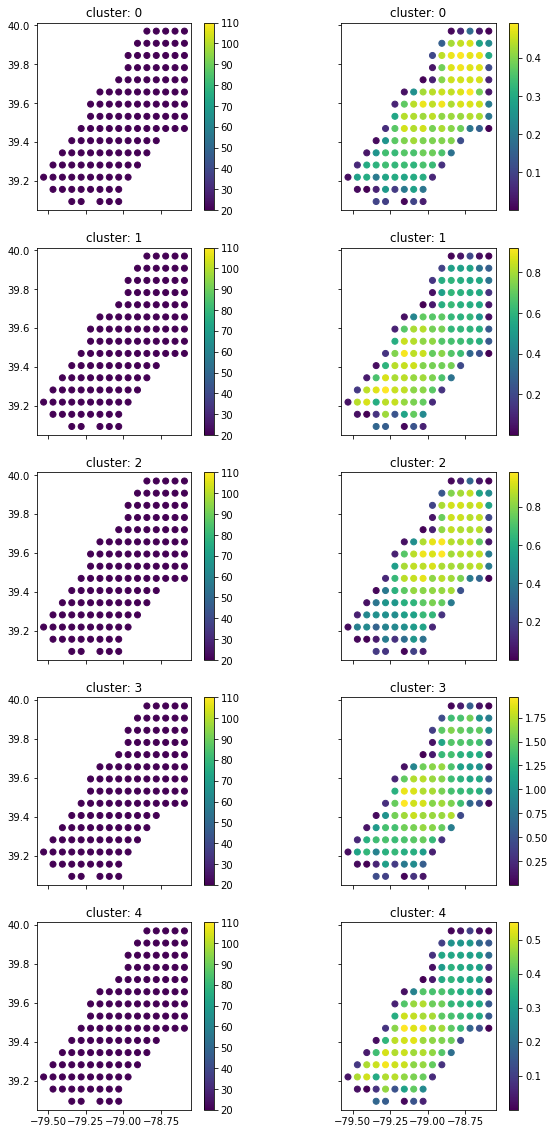

In [17]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20), sharex=True, sharey=True)
for column in range(2):
    for cluster in range(5):
        cluster_means.plot(ax=axs[cluster, column], column=cluster, vmin=20, vmax=110, legend = True) if column==0 else cluster_means.plot(ax=axs[cluster, column], column=cluster, legend=True)
        axs[cluster, column].set_title(f'cluster: {cluster}')

In [18]:
print(df.sum(axis=1))

1915-01-12    63.277956
1915-06-02    42.220130
1915-10-01    69.455329
1915-12-17    51.930428
1916-03-22    58.270076
                ...    
2011-06-19    39.331025
2011-09-05    40.798720
2011-09-06    79.194787
2011-09-07    61.178470
2011-12-07    38.580355
Length: 477, dtype: float64
